# Trend
Modeling long-term changes with moving averages and the time-dummy.

## What is trend?
The trend component of a time series represents a persistent, long-term change in the mean of a time-series. The trend is the slowest-moving part of a series, teh part represetning the largest time scale of importance.

## Moving average plots
To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time-series, we compute the average of teh values within a sliding window of some defined width. Each point of the graph represents the average of all the values in the series that fall within the window on either side. This smooths out any short term fluctuations in the series so that only long-term changes remain.

## Engineering trend
Once the cshape of the trend is identified, we can attempt to model it using a time-step feature. Using the time dummy we can model this with a linear trend

```target = a * time + b (y = mx + b)```

Other types of trends can be fit through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we add the square of the time dummy to the feature set, giving us:

```target = a * time ** 2 + b * time + c (y = ax**2 + bx + c)```

The ```LinearRegression``` model with learn the coefficients ```a, b,``` and ```c```.

## Example - Tunnel Traffic
An example using the Tunnel Traffic dataset.

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore") # Ignore warnings to clean up output cell 

# Set matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11,5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
)
plot_params = dict(
    color="0.75",
    style='.-',
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False
)

%config InlineBackend.figure_format = 'retina'

In [14]:
# Load Tunnel Traffic dataset
data_url = 'https://raw.githubusercontent.com/vbloise3/kaggle/master/tunnel.csv'
tunnel = pd.read_csv(data_url, 
                    parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


## Create the moving average 
Tunnel is a series of daily observations. Given this, the window of 265 days to smooth any short-term changes within the year will be used. 

To create a moving average, we fist start with the ```rolling``` method. This will facilitate the windowed computation necessary to generate the moving average. To compute the average of the 365 day window we chain the ```mean``` method to the ```rolling``` method. 

In [15]:
moving_average = tunnel.rolling(
    window=365, # 365-day window
    center=True, # Centers the average in the window
    min_periods=183, # Half the window size
).mean() # Computes the mean but could be any aggregate statistic

<Axes: title={'center': 'Tunnel Traffic - 265-Day Moving Average'}, xlabel='Day'>

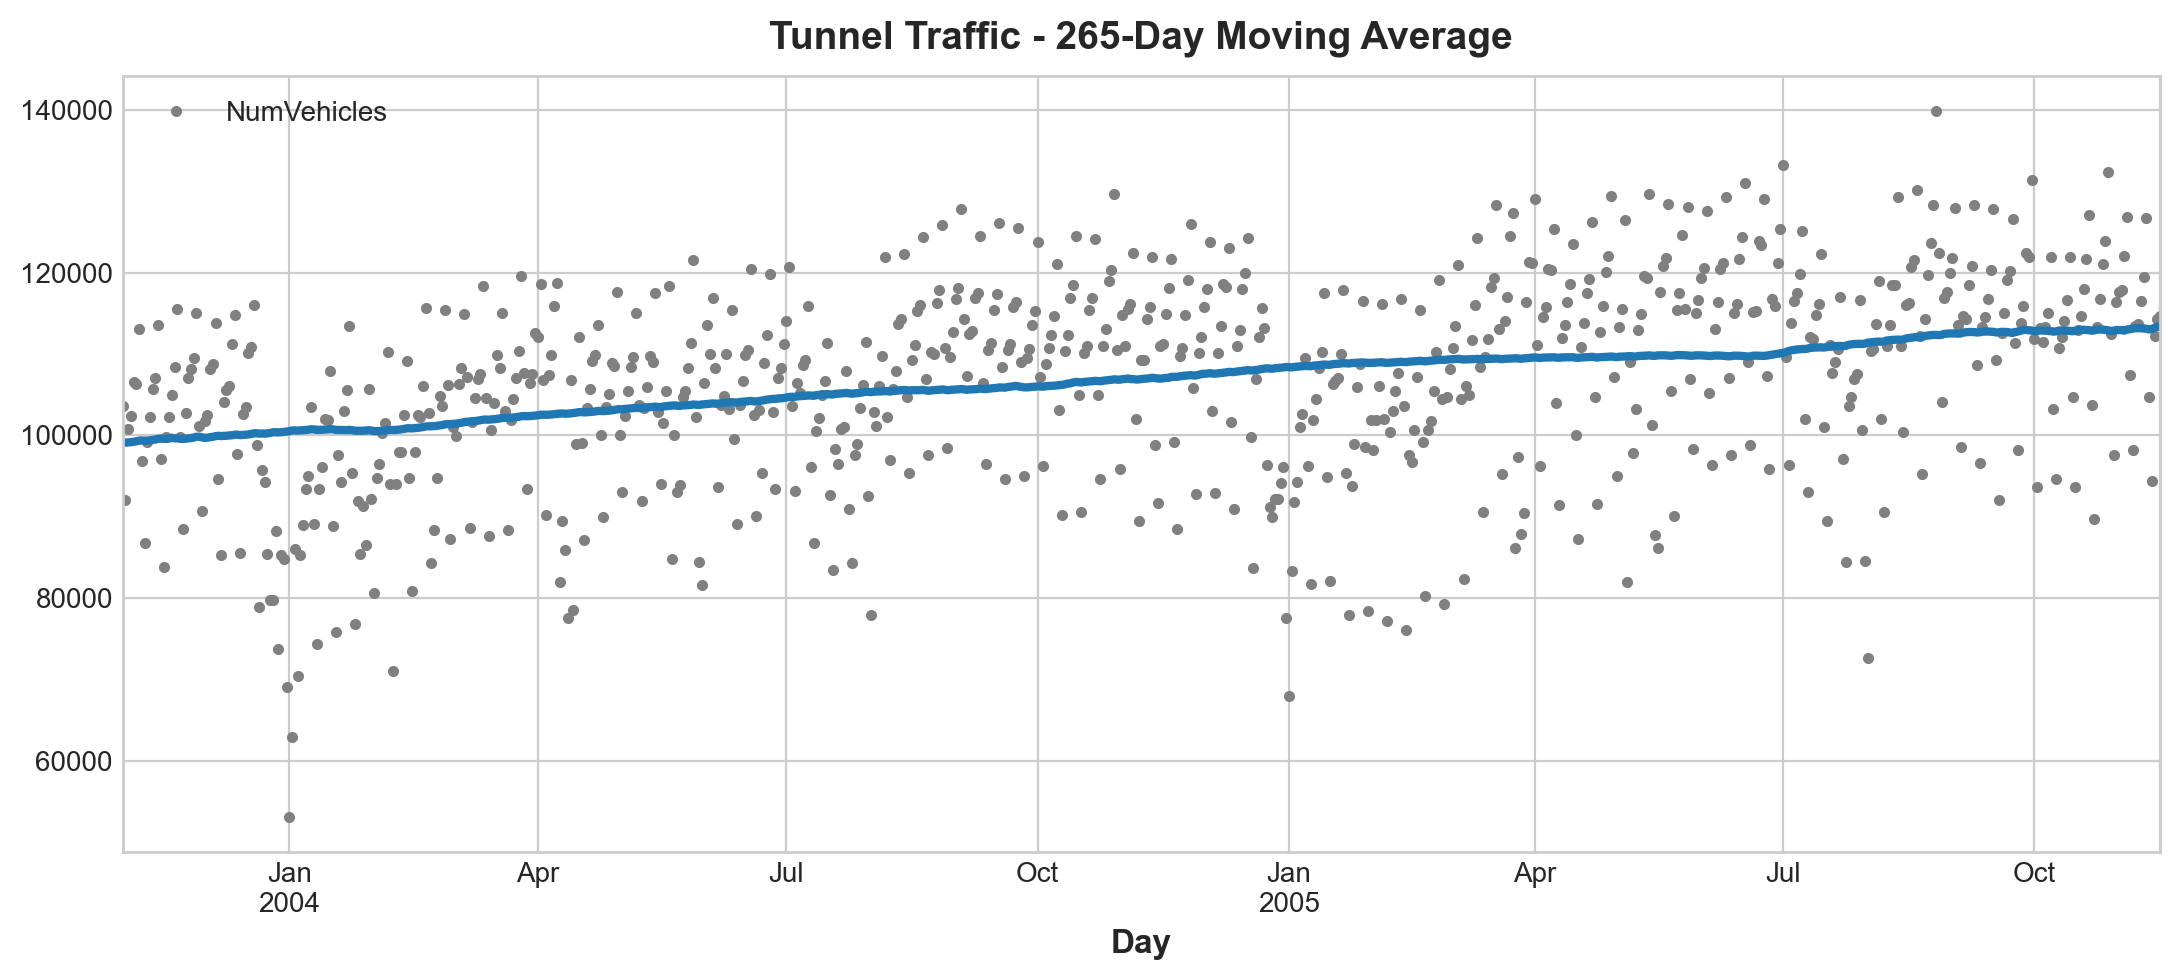

In [18]:
# Plot the moving average
ax = tunnel.plot(style=".", color="0.5") # Plots the raw tunnel data
moving_average.plot(
    ax=ax,
    linewidth=3,
    title="Tunnel Traffic - 265-Day Moving Average",
    legend=False)

## Engineer the time dummy using DeterministicProcess
Rather than engineer the time dummy in Pandas directly it can be done with the ```statsmodels``` library called ```DeterministicProcess```. The function helps avoid failure cases that can arise with time series and linear regression. 

The ```order``` argument in ```DeterministicProcess``` refers to the polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on. 

In [28]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index, # Dates from the training data
    constant=True, # Dummy feature for the bias (y_intercept)
    order=1, # The time dummy (trend)
    drop=True # Drop terms if necesary to avoid collinearity
)

# in_sample creates features for the dates given in the index argument 
X = dp.in_sample()
print(type(dp))
X.head()

<class 'statsmodels.tsa.deterministic.DeterministicProcess'>


,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


A deterministic process is a technical term for a time-series that is non-random or completely determined. Put more simply, these are time series that exhibit trend and/or seasonality patterns. 

In [30]:
# print(tunnel)

In [32]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles'] # NumVehicles is the thing we are trying to predict (the target)

# The intercept is the same as the the 'const' feature from 
# DeterministicProcess (X). LinearRegression behaves badly with duplicated features.
# It must be excluded here to avoid this bad behavior. 

model = LinearRegression(fit_intercept=False)
model.fit(X,y) # Recall that X is the time dummy created with DeterministicProcess

y_pred = pd.Series(model.predict(X), index=X.index)

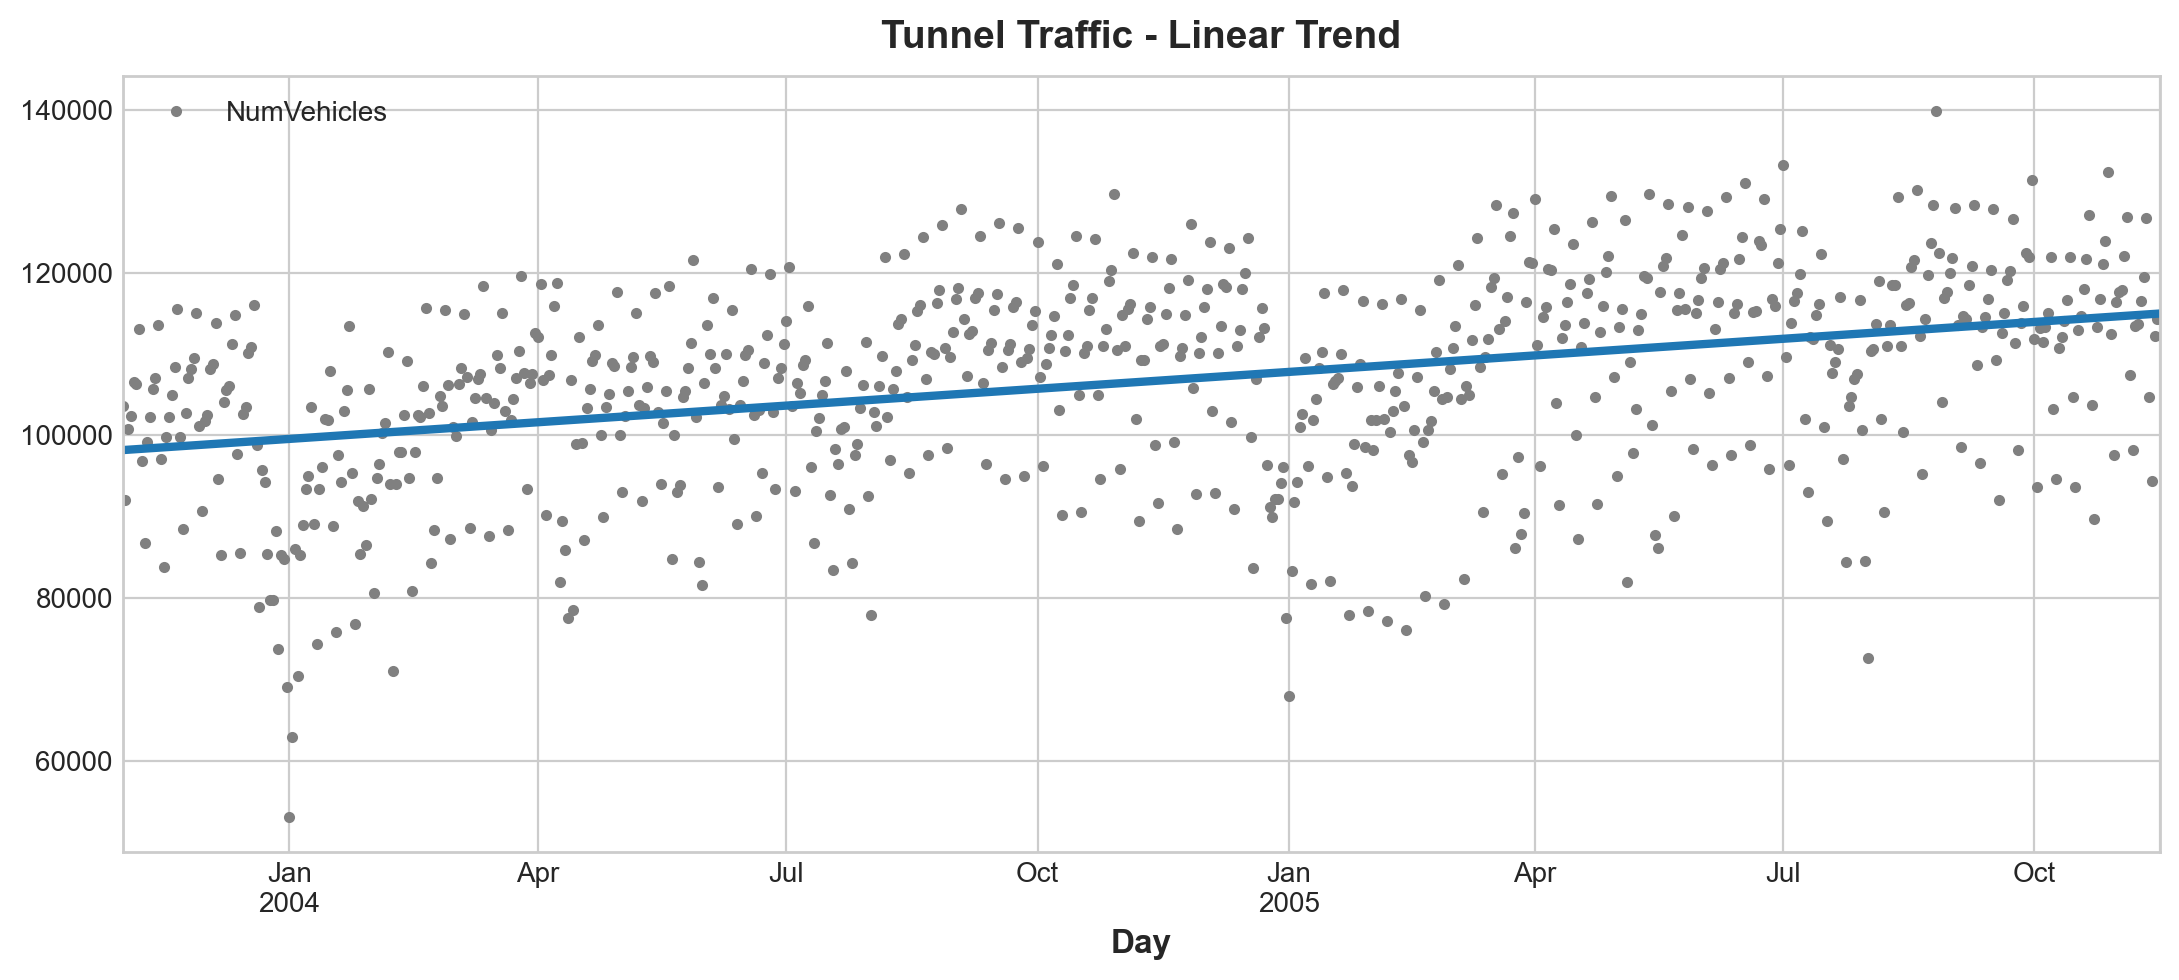

In [36]:
# Plot the NumVehicle data with the LinearRegression model
ax = tunnel.plot(style='.', 
                color="0.5",
                title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax,
               linewidth=3,
               label="Trend")
# plt.legend()

The trend discovered by the ```LinearRegression``` model is almost identical to the moving average plot. This suggests that a linear trend was the right order polynomial. 

## Make a forecast
To make a forecast, we apply our model to "out of sample" features. The "out of sample" features refer to times outside the observation period of the training data. 

Make a forecast for a 30-day "out of sample".

In [39]:
X = dp.out_of_sample(steps=30) # This is the DeterministicProcess time dummy 
X.head()

,const,trend
2005-11-17,1.0,748.0
2005-11-18,1.0,749.0
2005-11-19,1.0,750.0
2005-11-20,1.0,751.0
2005-11-21,1.0,752.0


In [42]:
y_fore = pd.Series(model.predict(X), index=X.index) # Predicted values 
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Plot a portion of the time series to see the trend forecast for the next 30 days.

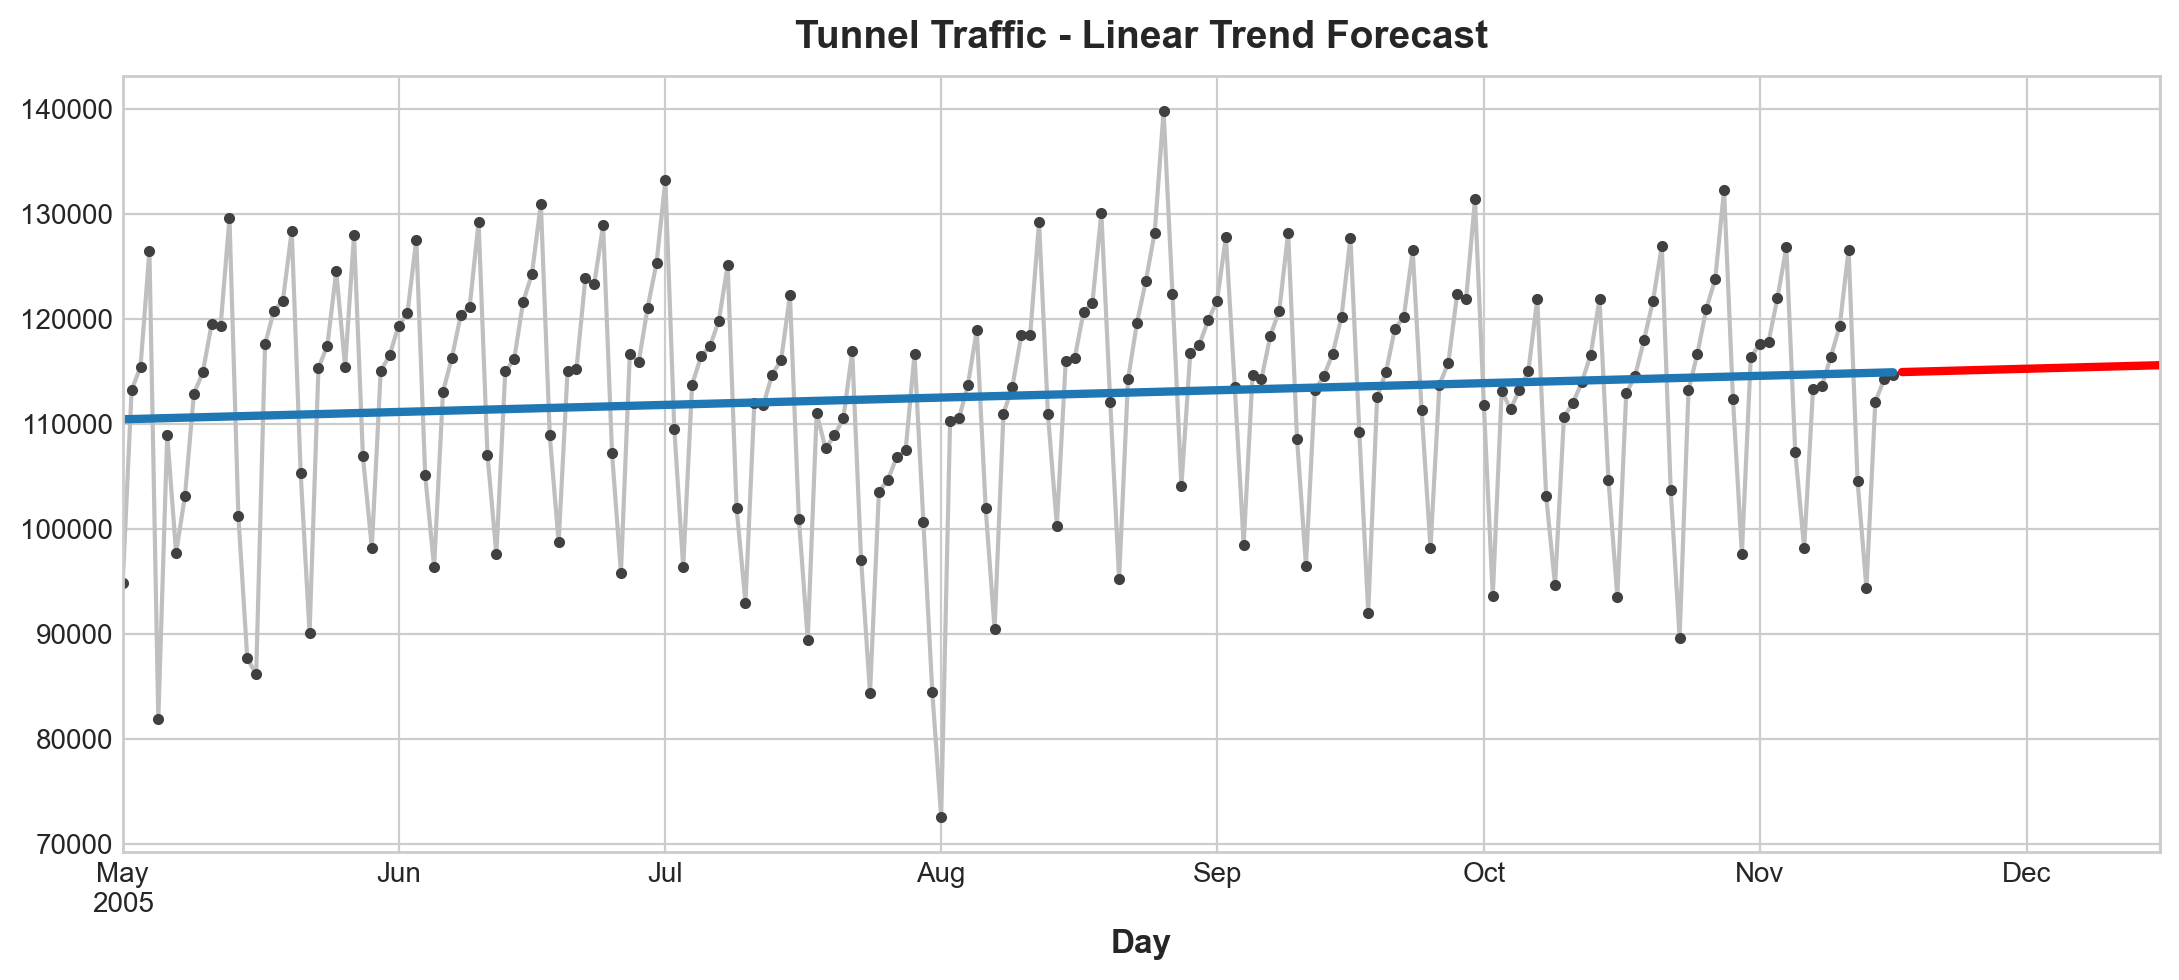

In [48]:
# ax = tunnel["2005-05":].plot(title='Tunnel Traffic - Linear Trend Forecast',
#                             **plot_params)
ax = tunnel["2005-05":].plot(title='Tunnel Traffic - Linear Trend Forecast',
                            **plot_params)
ax = y_pred["2005-05":].plot(ax=ax,
                linewidth=3,
                label='Trend')
ax = y_fore["2005-05":].plot(ax=ax,
                linewidth=3,
                label="Trend Forecast",
                color="red")

The models here act as a useful baseline or starting point for more sophisticated models. They can also be used as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests_